# Declare CNN-VAE
(Taken from https://keras.io/examples/variational_autoencoder_deconv/)

In [40]:
import math
import os
import os.path as osp
from glob import glob
import re

import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [41]:
def plot_results(models,
                 data,
                 batch_size=128,
                 digit_size=100,
                 figsize=(12, 4),
                 grid_range=(-1, 1),
                 n=10,
                 ndims=2,
                 dims=[0,1],
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    
    y_test_n = [int(re.search('pp(.*)_', y).group(1)) for y in y_test]
    
    sc = ax[0].scatter(z_mean[:, dims[0]], z_mean[:, dims[1]], c=y_test_n)
    plt.colorbar(sc, ax=ax)
    ax[0].set_xlabel("z[{}]".format(dims[0]))
    ax[0].set_ylabel("z[{}]".format(dims[1]))

    
    # display a 30x30 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(*grid_range, n)
    grid_y = np.linspace(*grid_range, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.zeros((1, ndims))
            z_sample[:, dims[0]] = xi
            z_sample[:, dims[1]] = yi
            #print(z_sample.shape)
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    ax[1].set_xticks(pixel_range)
    ax[1].set_yticks(pixel_range)
    ax[1].set_xticklabels(sample_range_x)
    ax[1].set_yticklabels(sample_range_y)
    ax[1].set_xlabel("z[{}]".format(dims[0]))
    ax[1].set_ylabel("z[{}]".format(dims[1]))
    ax[1].imshow(figure, cmap='Greys_r')

In [42]:
from scipy import misc
from PIL import Image
from sklearn.model_selection import train_test_split

def load_data(dir_path, img_size=None, onebatch=False):
    # list img files
    img_glob = osp.join(dir_path, '**', '*.png')
    img_paths = glob(img_glob, recursive=True)
    print(f'Found {len(img_paths)} images.')
    
    # split data
    subjects = list(set([osp.splitext(osp.basename(p))[0] for p in img_paths]))
    if onebatch:
        _, subjects_kept = train_test_split(subjects, test_size=0.025)
    else:
        subjects_kept = subjects
    sub_train, sub_test = train_test_split(subjects_kept)
    print(f'Train set: {len(sub_train)}')
    print(f'Test set: {len(sub_test)}')

    # calculate params
    s = np.asarray(Image.open(img_paths[0])).shape
    offs = (0, 0) if img_size is None else ((s[0]-img_size[0])//2, (s[1]-img_size[1])//2)
    size = s if img_size is None else img_size
    
    # init placeholders
    n_train = len(img_paths) // len(subjects) * len(sub_train)
    n_test = len(img_paths) // len(subjects) * len(sub_test)
    x_train = np.zeros((n_train, *size))
    x_test = np.zeros((n_test, *size))
    y_train = np.zeros((n_train), dtype=object)
    y_test = np.zeros((n_test), dtype=object)
    i_train = 0
    i_test = 0
    
    # load and add to matrix
    for p in tqdm(img_paths):
        name = osp.splitext(osp.basename(p))[0]
        # place in correct set
        if name in sub_train:
            img = np.asarray(Image.open(p))
            x_train[i_train] = img[offs[0]:-offs[0], offs[1]:-offs[1]]
            y_train[i_train] = name
            i_train += 1
        elif name in sub_test:
            img = np.asarray(Image.open(p))
            x_test[i_test] = img[offs[0]:-offs[0], offs[1]:-offs[1]]
            y_test[i_test] = name
            i_test += 1
        else:
            #print('#### WHOS THIS IMG FROM??? ', name)
            pass
    return (x_train, y_train), (x_test, y_test)

In [44]:
# dataset
(x_train, y_train), (x_test, y_test) = load_data('./data/hutubs_img/', img_size=(96,96), onebatch=False)
print('train X, Y:', x_train.shape, y_train.shape)
print('test  X, Y:', x_test.shape, y_test.shape)

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

  3%|▎         | 361/13310 [00:00<00:03, 3601.21it/s]

Found 13310 images.
Train set: 41
Test set: 14


100%|██████████| 13310/13310 [00:03<00:00, 3779.30it/s]


train X, Y: (9922, 96, 96) (9922,)
test  X, Y: (3388, 96, 96) (3388,)


In [46]:
# network parameters
input_shape = (image_size, image_size, 1)
kernel_size = 3
layers = 3
filters = 32
inter_dim = 64
latent_dim = 32

batch_size = 256
epochs = 1000

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(layers):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(inter_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='plots/vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(layers):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='plots/vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# VAE loss = mse_loss + kl_loss
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae, to_file='plots/vae_cnn.png', show_shapes=True)

models = (encoder, decoder)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 48, 48, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 24, 24, 128)  73856       conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 12, 12, 256)  295168      conv2d_20[0][0]                  
__________________________________________________________________________________________________
flatten_7 

In [ ]:
# train the autoencoder
res = vae.fit(x_train,
        epochs=150,
        batch_size=batch_size,
        validation_data=(x_test, None))


Train on 9922 samples, validate on 3388 samples
Epoch 1/150
9922/9922 [==============================] - 11s 1ms/step - loss: 11.0076 - val_loss: 9.9447
Epoch 2/150
9922/9922 [==============================] - 11s 1ms/step - loss: 11.0344 - val_loss: 10.0192
Epoch 3/150
9922/9922 [==============================] - 11s 1ms/step - loss: 11.0197 - val_loss: 9.9410
Epoch 4/150
9922/9922 [==============================] - 11s 1ms/step - loss: 11.0177 - val_loss: 9.9681
Epoch 5/150
9922/9922 [==============================] - 11s 1ms/step - loss: 10.9992 - val_loss: 10.0258
Epoch 6/150
9922/9922 [==============================] - 11s 1ms/step - loss: 11.0036 - val_loss: 10.0301
Epoch 7/150
9922/9922 [==============================] - 11s 1ms/step - loss: 11.0326 - val_loss: 9.9128
Epoch 8/150
9922/9922 [==============================] - 11s 1ms/step - loss: 11.0306 - val_loss: 9.9994
Epoch 9/150
9922/9922 [==============================] - 12s 1ms/step - loss: 11.0184 - val_loss: 9.9493
Epoc

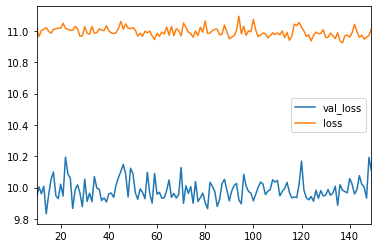

In [53]:
trainig_history = res.history
pd.DataFrame(trainig_history).iloc[10:].plot()

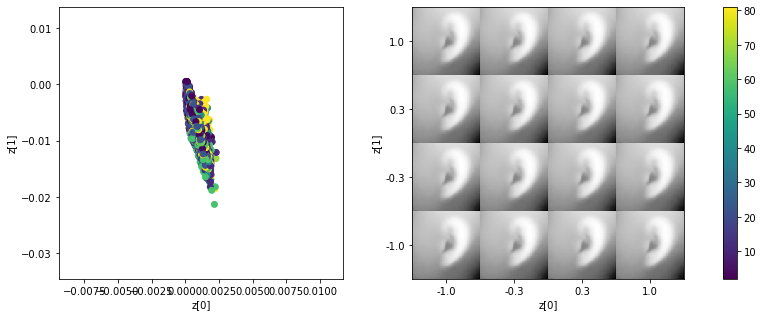

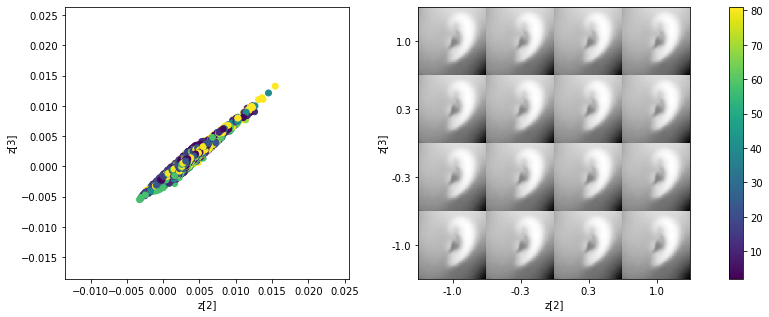

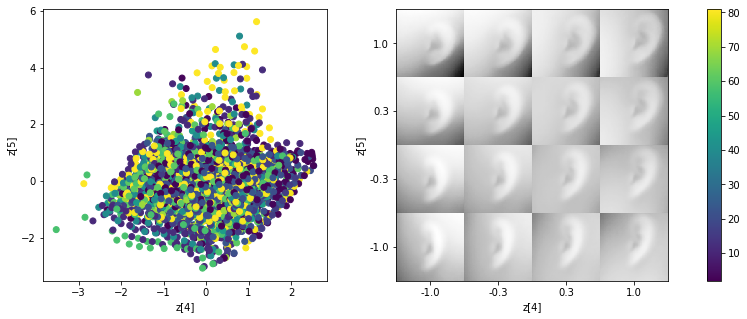

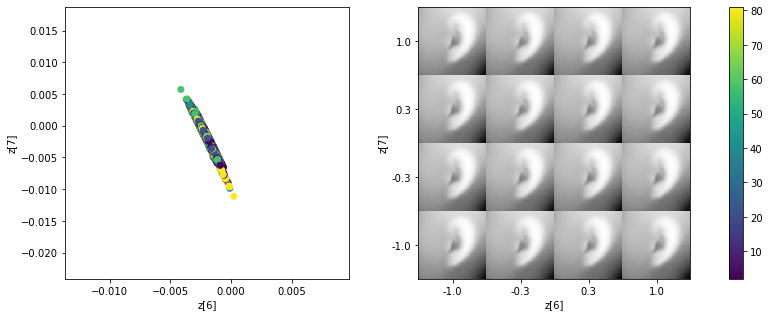

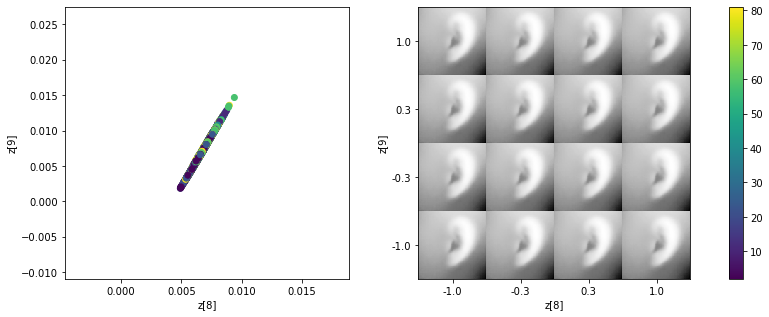

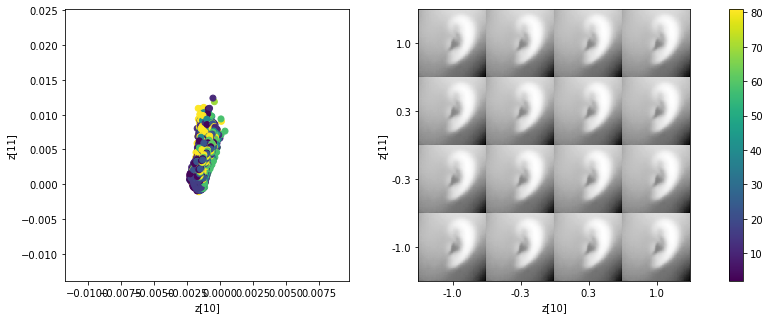

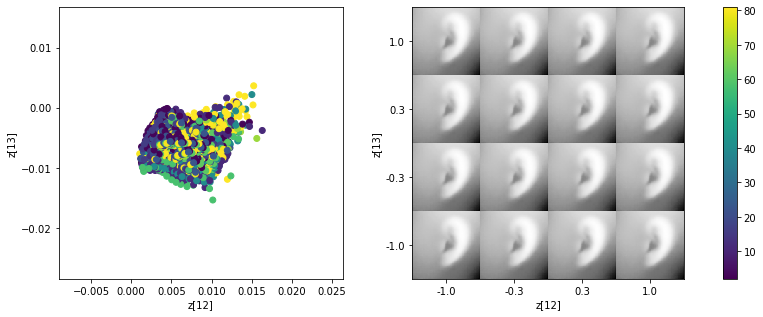

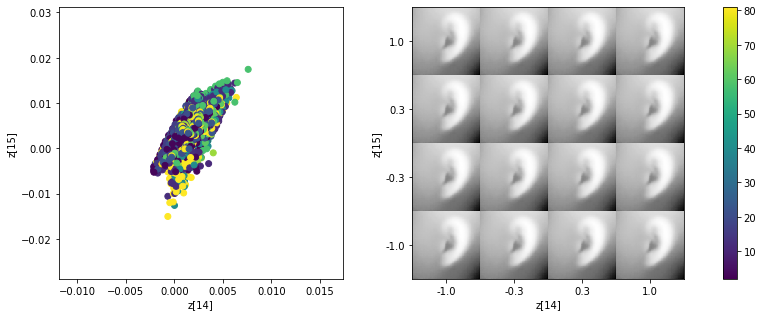

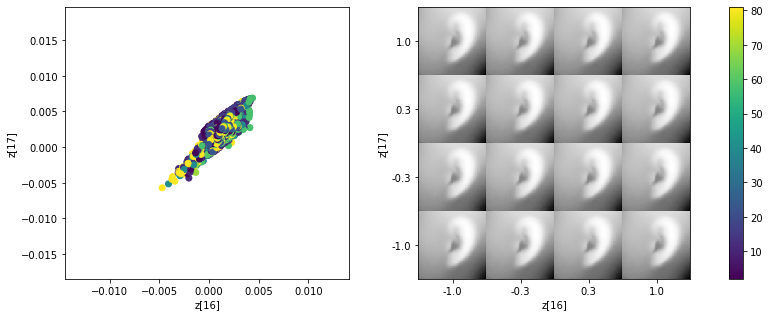

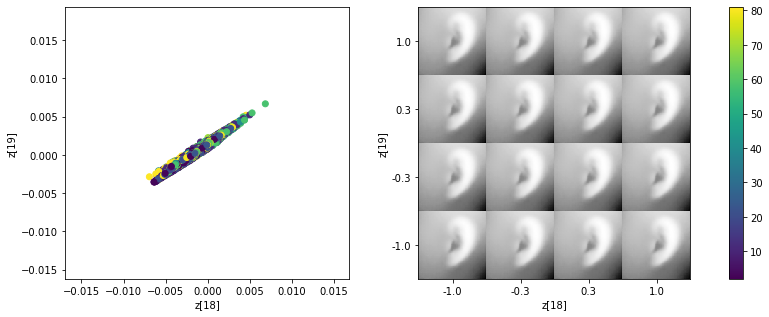

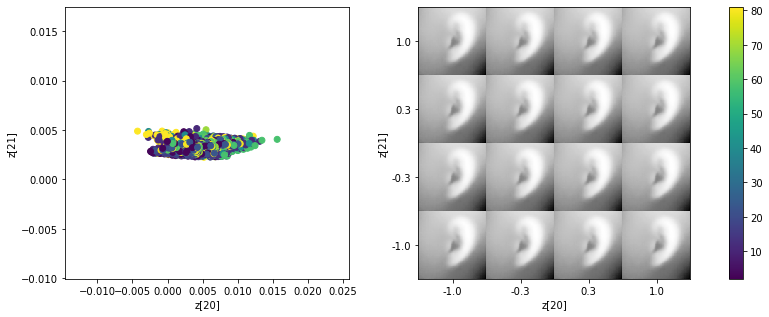

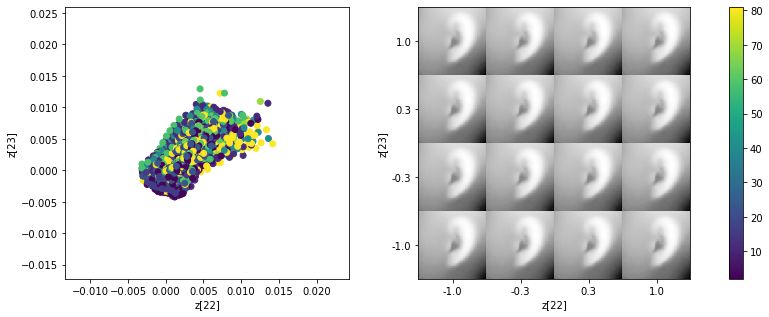

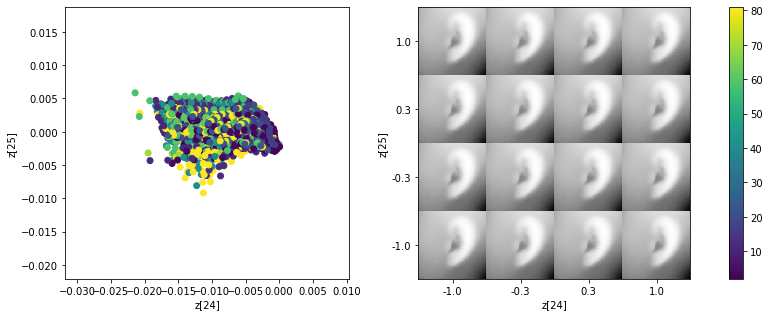

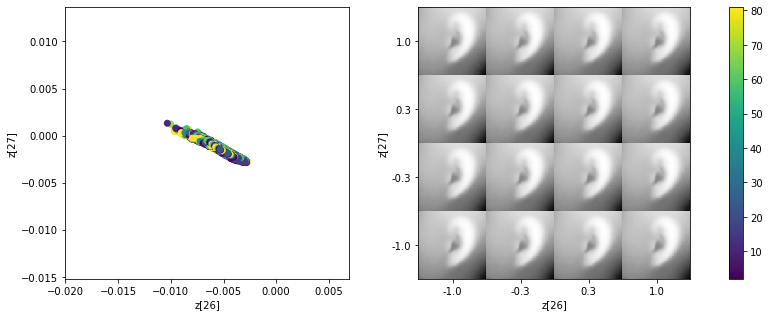

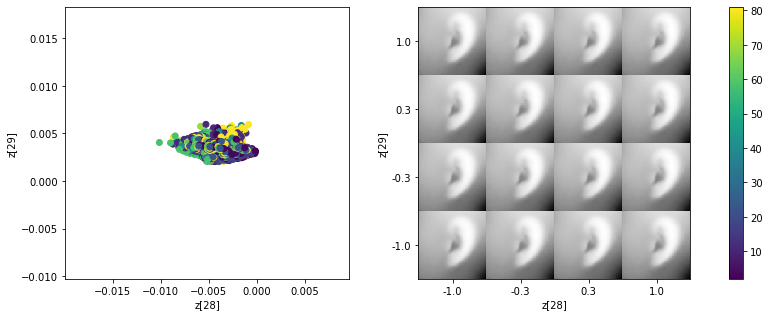

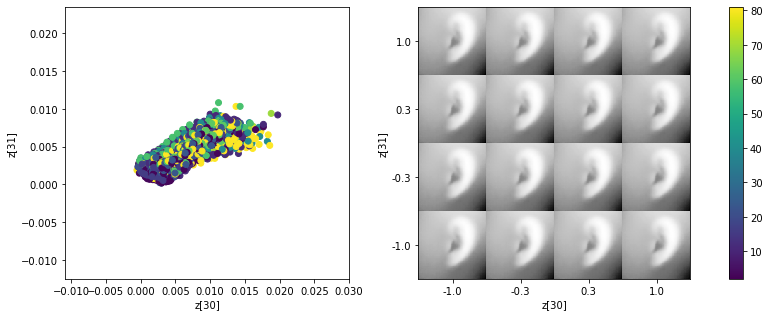

In [54]:
for dims in np.arange(32).reshape((16, 2)): 
    plot_results(models, (x_test, y_test), 
                 batch_size=batch_size, 
                 digit_size=96, 
                 figsize=(14, 5),
                 n=4,
                 model_name="vae_cnn", 
                 ndims=latent_dim, 
                 dims=dims)